# Language Translation

In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import torchtext
from torchtext.vocab import Vocab
from torchtext.data import Field, BucketIterator, TabularDataset

from torchsummary import summary

import spacy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import time
import math
from PIL import Image
import glob
from IPython.display import display

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
torch.manual_seed(1)
np.random.seed(1)

HYPERPARAMETERS

In [4]:
BATCH_SIZE = 16
LR = 3e-4
NUM_EPOCHES = 10

## Preprocessing

Downloading trained pipelines from spacy

In [5]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [6]:
nlp_english = spacy.load("en_core_web_sm")

In [7]:
nlp_german = spacy.load("de_core_news_sm")

In [8]:
def tokenizer_english(text):
    return [token.text for token in nlp_english.tokenizer(text)]

In [9]:
def tokenizer_german(text):
    return [token.text for token in nlp_german.tokenizer(text)]

In [10]:
tokenizer_english("Hi guys, my name Jeff")

['Hi', 'guys', ',', 'my', 'name', 'Jeff']

In [11]:
tokenizer_german("I dont know any German")

['I', 'dont', 'know', 'any', 'German']

In [12]:
ENGLISH = torchtext.data.Field(tokenize=tokenizer_english, lower=True, init_token="<sos>", eos_token="<eos>")

In [13]:
GERMAN = torchtext.data.Field(tokenize=tokenizer_german, lower=True, init_token="<sos>", eos_token="<eos>")

In [14]:
train, validation, test = torchtext.datasets.Multi30k.splits(exts=(".de", ".en"), fields=(GERMAN, ENGLISH))

In [15]:
ENGLISH.build_vocab(train, max_size=10000, min_freq=1)

In [16]:
GERMAN.build_vocab(train, max_size=10000, min_freq=1)

In [17]:
print("ENGLISH vocab_size: ", len(ENGLISH.vocab))
print("GERMAN vocab_size: ", len(GERMAN.vocab))

ENGLISH vocab_size:  9797
GERMAN vocab_size:  10004


In [18]:
train_dataloader, validation_dataloader, test_dataloader = torchtext.data.BucketIterator.splits(
    (train, validation, test),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

In [19]:
for batch_idx, data in enumerate(train_dataloader):
    print(batch_idx)
    print(data.src.size())
    print(data.trg.size())
    break

0
torch.Size([13, 16])
torch.Size([17, 16])


In [20]:
def german2english(model, german_sentence, device="cpu", max_len=100):
    model.eval()
    tokens = [token.text.lower() for token in nlp_german(german_sentence)]
    tokens = ["<sos>"] + tokens + ["<eos>"]
    
    indexes = [GERMAN.vocab.stoi[token] for token in tokens]
    indexes_tensor = torch.LongTensor(indexes).unsqueeze(1).to(device)
    
    english_sentence = [ENGLISH.vocab.stoi["<sos>"]]
    
    for i in range(max_len):
        trg = torch.LongTensor(english_sentence).unsqueeze(1).to(device)

        with torch.no_grad():
            word = model(indexes_tensor, trg)
            
        top = word.argmax(-1)[-1, :].item()
        english_sentence.append(top)

        if top == ENGLISH.vocab.stoi["<eos>"]:
            break

    english_sentence = [ENGLISH.vocab.itos[word] for word in english_sentence]
    
    return english_sentence

In [21]:
ENGLISH.vocab.stoi["<pad>"]

1

## Model

In [22]:
from transformer_package.models import Transformer, Transformer_with_nn

In [23]:
source_vocab_size = len(GERMAN.vocab)
target_vocab_size = len(ENGLISH.vocab)
embed_size = 512
num_head = 8
num_ff = 1024
encoder_layers = 3
decoder_layers = 3
hidden_size = 512
dropout = 0.1

In [24]:
model = Transformer(source_vocab_size, target_vocab_size, embed_size, num_head, num_ff, encoder_layers, decoder_layers, hidden_size, dropout=dropout, device=device).to(device)
model

Transformer(
  (dropout_layer): Dropout(p=0.1, inplace=False)
  (encoder_embed): Embedding(10004, 512)
  (decoder_embed): Embedding(9797, 512)
  (encoder_positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder_positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoders): ModuleList(
    (0): Transformer_Encoder(
      (Norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (Norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (multi_attention): MultiHeadAttention(
        (dropout_layer): Dropout(p=0.1, inplace=False)
        (Q): Linear(in_features=512, out_features=512, bias=True)
        (K): Linear(in_features=512, out_features=512, bias=True)
        (V): Linear(in_features=512, out_features=512, bias=True)
        (linear): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): Sequential(
        (0): Linear(in_features=512, out_feature

In [25]:
def test(size):
    sample_in_x = torch.rand(100, BATCH_SIZE).type(torch.LongTensor).to(device)
    sample_in_y = torch.rand(size, BATCH_SIZE).type(torch.LongTensor).to(device)
    sample_out = model(sample_in_x, sample_in_y)
    print("Dimenstions of Input Source Vector: ", sample_in_x.size())
    print("Dimenstions of Input Target Vector: ", sample_in_y.size())
    print("Dimenstions of Predicted Vector: ", sample_out.size())
    
test(90)
test(100)
test(110)

Dimenstions of Input Source Vector:  torch.Size([100, 16])
Dimenstions of Input Target Vector:  torch.Size([90, 16])
Dimenstions of Predicted Vector:  torch.Size([90, 16, 9797])
Dimenstions of Input Source Vector:  torch.Size([100, 16])
Dimenstions of Input Target Vector:  torch.Size([100, 16])
Dimenstions of Predicted Vector:  torch.Size([100, 16, 9797])
Dimenstions of Input Source Vector:  torch.Size([100, 16])
Dimenstions of Input Target Vector:  torch.Size([110, 16])
Dimenstions of Predicted Vector:  torch.Size([110, 16, 9797])


## Training

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = ENGLISH.vocab.stoi["<pad>"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)

In [27]:
loss_hist = {}
loss_hist["train loss"] = []
loss_hist["test loss"] = []

for epoch in range(1, NUM_EPOCHES+1):
    
    model.train()
    
    epoch_train_loss = 0
    epoch_test_loss = 0  
    
    for batch_idx, data in enumerate(train_dataloader):
        x = data.src.to(device)
        y = data.trg.to(device)
        
        y_pred = model(x, y[:-1, :])
        
        y_pred = y_pred.reshape(-1, y_pred.size(-1))
        y = y[1:, :].reshape(-1)
        
        optimizer.zero_grad()
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
        
    with torch.no_grad():
        model.eval()
        
        for batch_idx, data in enumerate(validation_dataloader):
            x = data.src.to(device)
            y = data.trg.to(device)
        
            y_pred = model(x, y[:-1, :])
            y_pred = y_pred.reshape(-1, y_pred.size(-1))
            y = y[1:, :].reshape(-1)
        
            loss = criterion(y_pred, y)
        
            epoch_test_loss += loss.item()
    
    epoch_train_loss = epoch_train_loss / len(train_dataloader.dataset)
    epoch_test_loss = epoch_test_loss / len(validation_dataloader.dataset)
    
    loss_hist["train loss"].append(epoch_train_loss)
    loss_hist["test loss"].append(epoch_test_loss)
    
    if epoch%1 == 0:
        print(german2english(model, "Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.", device=device)) # Two young, White males are outside near many bushes.
        print("-------------------------------------------------")
        print("Epoch: {} Train mean loss: {:.8f}".format(epoch, epoch_train_loss))
        print("       {} Test  mean loss: {:.8f}".format(epoch, epoch_test_loss))
        print("-------------------------------------------------")

['<sos>', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a', 'man', 'in', 'a']
-------------------------------------------------
Epoch: 1 Train mean loss: 0.30136652
       1 Test  mean loss: 0.25347116
-------------------------------------------------
['<sos>', 'a', 'group', 'of', 'people', 'are', 'playing', 'in', 'a', 'group', 'of', 'people', 'are', 'playing', 'in', 'a', 'large', 'group', 'of', 'people', 'are', 'playing', 'in', 'a', 'large', 'group', 'of', 'people

## Test

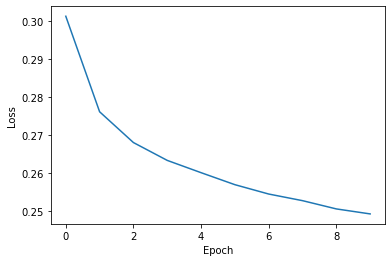

In [28]:
plt.plot(loss_hist["train loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

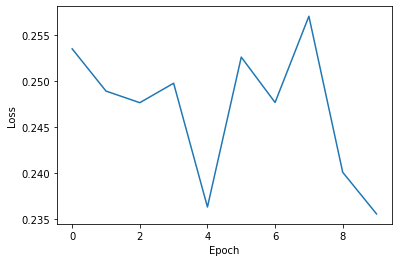

In [29]:
plt.plot(loss_hist["test loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [30]:
german2english(model, "Ein Mann mit einem orangefarbenen Hut, der etwas anstarrt.", device=device) # A man in an orange hat starring at something.

['<sos>',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a',
 'man',
 'in',
 'a']

## Saving Model

In [31]:
#torch.save(model, "trained_models/language_translation_1.pt")